### BASE (Papermill) >> Analysis of cannibalisation during PROMOTIONAL periods using Causal Impact (per store)


* Read the department/store data
* Read the calculated availability data or calculate it on demand
* Compare PROMO sales vs NON PROMO given the availabily
* Find the products that change their average sales
* Pick a pair of products and try the sales weighted distance analysis
* Saves the pairs in 'sku_pair_analysis'

This notebook comes from the experiments in `CFAV_simulate_cannibalisation_CausalImpact.ipynb`


Updates:

26.10.2020 - First attempt to out it all together

31.10.2020 - Adding post-promotional checks

06.11.2020 - Add the trend of the total sales

25.11.2020 - (Apart from Mom's bday) Adding the covariates for robust estimation

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import fcn_helpers as fhelp
import fcn_simulation as fsim
from causalimpact import CausalImpact
import promotional_helpers as promies
from statsmodels.tsa.seasonal import STL

#plt.rcParams['figure.figsize'] = [14, 7]
fhelp.makeFolder('results')
pd.options.display.max_rows = None
# Use v2.0 colour cycle
def_colours = plt.rcParams['axes.prop_cycle'].by_key()['color']
# Fig sizes
fig_h = 10
fig_w = 18

# inliners
fcn_compare = lambda a,b: abs(a-b)/max(a,b)
fcn_compare_snap_vs_regular = lambda snap,reg: snap/reg
mapper_family_to_category = fhelp.cfav_get_map_dept_to_cat()

In [2]:
dataFolder = os.path.expanduser('~/Google Drive/order/Machine Learning Part/data/CorporacionFavorita')
xlsx_path = os.path.expanduser('~/Google Drive/order/Machine Learning Part/data/CorporacionFavorita')
graphsFolder = fhelp.fullfile(dataFolder, 'graphs_cannibalisation')
gephiFolder = fhelp.fullfile(dataFolder, 'gephi_files')
results_folder = 'CausalImpactResultsCovariates'

In [3]:
# Save the plots
save_all_cannibals = False

store_name = 'Pichincha_47_A_14'
#store_name = 'Pichincha_49_A_11'
dept_id = 'LIQUOR,WINE,BEER'
dept_id ='BREAD_BAKERY'
#dept_id ='FROZEN+FOODS'
dept_id = 'DAIRY'
dept_id = 'GROCERY_I'
dept_id = 'PRODUCE'

# variables that pertain to the new code

# Potential cannibals
# This threshold is used to detect uplifters based on the difference in average sales
sales_threshold = 1/3
# min AVG sales to be considered
min_avg_sales = 10


# This is the minimum bump between regular and promo
# and promo back to regular *0.25
min_diff_in_units_from_reg_to_promo = 10
# when analysing the SKUs
min_promo_days=3
min_regular_days=6

# values for the CI analysis
min_ratio_change = 0.4
do_exclude_promos_SKU_B = True
# This flag is pretty good for debugging/development
be_verbose=False



# LOESS - weekly
period_in_days = 7

# If true, use the sales without the weekly pattern
do_decomposition = False


# This threshold is used to detect the reduction in sales that one uplifter causes
cannibalisation_threshold = 1/3

# min days/times that both products overlap during the promotions of the cannibal
min_snap_days = 10

# N/A
#price_threshold = 2

In [4]:
# Parameters
dept_id = "GROCERY_I"
min_diff_in_units_from_reg_to_promo = 10
store_name = "Pichincha_49_A_11"
min_promo_days = 3
min_regular_days = 6
min_ratio_change = 0.5
do_exclude_promos_SKU_B = True
be_verbose = False
sales_threshold = 0.3333333333333333
min_avg_sales = 7
period_in_days = 7
do_decomposition = False
cannibalisation_threshold = 0.3333333333333333
min_snap_days = 10


#### Read the store level data

In [5]:
# Read departement sales for the current store
category_id = mapper_family_to_category.get(dept_id, '')
foldername = os.path.join(dataFolder, category_id, dept_id, 'store_sales')
filename = os.path.join(foldername, f'{store_name}.pickle')
df_store = fhelp.readPickleFile(filename)

sales_vars = [iVar for iVar in df_store.columns if 'sales-' in iVar]
promotion_vars = [iVar for iVar in df_store.columns if 'promotion_flag-' in iVar]

df_store.head(2)

,date,weekdays,sales-GROCERY_I_96995-Pichincha_49_A_11,promotion_flag-GROCERY_I_96995-Pichincha_49_A_11,sales-GROCERY_I_99197-Pichincha_49_A_11,promotion_flag-GROCERY_I_99197-Pichincha_49_A_11,sales-GROCERY_I_103520-Pichincha_49_A_11,promotion_flag-GROCERY_I_103520-Pichincha_49_A_11,sales-GROCERY_I_105574-Pichincha_49_A_11,promotion_flag-GROCERY_I_105574-Pichincha_49_A_11,...,promotion_flag-GROCERY_I_2131699-Pichincha_49_A_11,sales-GROCERY_I_2132163-Pichincha_49_A_11,promotion_flag-GROCERY_I_2132163-Pichincha_49_A_11,sales-GROCERY_I_2132318-Pichincha_49_A_11,promotion_flag-GROCERY_I_2132318-Pichincha_49_A_11,sales-GROCERY_I_2132945-Pichincha_49_A_11,promotion_flag-GROCERY_I_2132945-Pichincha_49_A_11,sales-GROCERY_I_2132957-Pichincha_49_A_11,promotion_flag-GROCERY_I_2132957-Pichincha_49_A_11,total_units
0,2017-01-01,Sunday,0.0,False,0.0,False,0.0,False,0.0,False,...,False,0.0,False,0.0,False,0.0,False,0.0,False,0.0
1,2017-01-02,Monday,0.0,False,4.0,False,6.0,False,17.0,False,...,False,0.0,False,0.0,False,0.0,False,0.0,False,15363.0


#### Add weather data

In [6]:
weather_file = os.path.join(dataFolder, 'weather_data','daily_weather_in_Quito2017_no_header.pickle')
df_weather = pd.read_pickle(weather_file)[['date', 'avg_temp','wind_speed','total_precipitation', 'T2M_MAX_adj', 'T2M_MIN_adj']]

df_store = pd.merge(df_store, df_weather, how='inner', on='date')

#### Add the trend of the department sales

In [7]:
sales_decomposition_LOESS = STL(df_store['total_units'], period=period_in_days).fit()
df_store['total_units_trend'] = sales_decomposition_LOESS.trend
df_store.head(2)

,date,weekdays,sales-GROCERY_I_96995-Pichincha_49_A_11,promotion_flag-GROCERY_I_96995-Pichincha_49_A_11,sales-GROCERY_I_99197-Pichincha_49_A_11,promotion_flag-GROCERY_I_99197-Pichincha_49_A_11,sales-GROCERY_I_103520-Pichincha_49_A_11,promotion_flag-GROCERY_I_103520-Pichincha_49_A_11,sales-GROCERY_I_105574-Pichincha_49_A_11,promotion_flag-GROCERY_I_105574-Pichincha_49_A_11,...,promotion_flag-GROCERY_I_2132945-Pichincha_49_A_11,sales-GROCERY_I_2132957-Pichincha_49_A_11,promotion_flag-GROCERY_I_2132957-Pichincha_49_A_11,total_units,avg_temp,wind_speed,total_precipitation,T2M_MAX_adj,T2M_MIN_adj,total_units_trend
0,2017-01-01,Sunday,0.0,False,0.0,False,0.0,False,0.0,False,...,False,0.0,False,0.0,11.03,3.62,6.29,20.139417,8.599041,7939.384189
1,2017-01-02,Monday,0.0,False,4.0,False,6.0,False,17.0,False,...,False,0.0,False,15363.0,11.13,4.15,4.42,20.100002,8.515361,8601.133109


In [8]:


category_id = mapper_family_to_category.get(dept_id, '')
foldername = os.path.join(dataFolder, results_folder, category_id, dept_id)
fhelp.makeFolder(foldername)
filename = os.path.join(foldername, f'{dept_id}-{store_name}.pickle')

#### Exclude the holiday periods from the analysis
Include it in the skus's heartbeat in the analysis below

In [9]:
preXmas  = df_store.date >= '2016-12-21'
postXmas = df_store.date < '2017-01-04'
idx_Xmas = (preXmas & postXmas).values


# at the moment only Xmas
idx_holiday_to_exclude = idx_Xmas

#### Read the store level sales decomposition
Generate the file if required
- (sales)
- heartbeat
- trend
- seasonal 
- residual

In [10]:
# Sales decomposition - on demand
folderDecomposition = os.path.join(os.path.expanduser(dataFolder), 'sku_decomposition', category_id, dept_id)
filename = os.path.join(folderDecomposition, f'{store_name}.pickle')

if os.path.exists(filename):
    df_components = fhelp.readPickleFile(filename)
else:
    decomposed_skus = []

    # Season-Trend decomposition using LOESS
    for idx_sku, sku_name in enumerate(sales_vars):

        item_id = sku_name.split('-')[1]

        current_sales = df_store[sku_name]

        df_decomposition = fhelp.decompose_signal(current_sales, \
            period_in_days=period_in_days, minimum_heartbeat=0.85)

        rename_map = {iCol: f'{iCol}-{item_id}-{store_name}' for iCol in df_decomposition.columns}
        decomposed_skus.append(df_decomposition.rename(columns=rename_map))

    df_components = pd.concat(decomposed_skus, axis=1)

    df_components['date'] = df_store.date
    df_components['weekdays'] = df_store.weekdays

    fhelp.makeFolder(folderDecomposition)
    fhelp.toPickleFile(df_components, filename)
    print(f'Saving {filename}...')
    
df_components.head(3)

,heartbeat_flag-GROCERY_I_96995-Pichincha_49_A_11,trend-GROCERY_I_96995-Pichincha_49_A_11,seasonal-GROCERY_I_96995-Pichincha_49_A_11,residual-GROCERY_I_96995-Pichincha_49_A_11,heartbeat_flag-GROCERY_I_99197-Pichincha_49_A_11,trend-GROCERY_I_99197-Pichincha_49_A_11,seasonal-GROCERY_I_99197-Pichincha_49_A_11,residual-GROCERY_I_99197-Pichincha_49_A_11,heartbeat_flag-GROCERY_I_103520-Pichincha_49_A_11,trend-GROCERY_I_103520-Pichincha_49_A_11,...,heartbeat_flag-GROCERY_I_2132945-Pichincha_49_A_11,trend-GROCERY_I_2132945-Pichincha_49_A_11,seasonal-GROCERY_I_2132945-Pichincha_49_A_11,residual-GROCERY_I_2132945-Pichincha_49_A_11,heartbeat_flag-GROCERY_I_2132957-Pichincha_49_A_11,trend-GROCERY_I_2132957-Pichincha_49_A_11,seasonal-GROCERY_I_2132957-Pichincha_49_A_11,residual-GROCERY_I_2132957-Pichincha_49_A_11,date,weekdays
0,False,3.055775e-07,-3.354229e-07,2.984536e-08,True,2.967571,-0.970268,-1.997303,True,2.919304,...,False,0.0,0.0,0.0,False,0.0,0.0,0.0,2017-01-01,Sunday
1,False,2.191664e-07,-3.206818e-07,1.015154e-07,True,3.756096,0.363197,-0.119293,True,2.778314,...,False,0.0,0.0,0.0,False,0.0,0.0,0.0,2017-01-02,Monday
2,False,1.405439e-07,-2.117219e-07,7.117804e-08,True,4.505673,-0.923200,2.417527,True,2.679423,...,False,0.0,0.0,0.0,False,0.0,0.0,0.0,2017-01-03,Tuesday


## Compare PROMOS sales vs NON PROMOS given the availabily (comparing windows of non-promos/promos)

Given the inferred availability of the SKU, calculate the following parameters for SNAP and regular periods: average sales and the standard deviation, the median and the number of days within each category.

```python
{'num_promo_slots': 2,
 'avg_promo_sales': 55.51020408163265,
 'avg_regular_sales': 41.74285714285714,
 'difference_averages_promo_to_regular': 13.76734693877551,
 'cum_difference_sales_promo_to_regular': -202.0,
 'slot_promo_avg_sales': array([56., 52.]),
 'slot_regular_avg_sales': array([37.38461538, 42.73684211]),
 'availability_value_sku_A': 0.986784140969163}
```


Then we simply select the uplifters as those SKUs that during SNAP periods have sales greater than:

'median_snap_sales'>=('median_regular_sales'*(1+sales_threshold))

### Comparison only valid if sales larger than zero
idx_B = (df_snap_stats['median_snap_sales']>0) & (df_snap_stats['median_regular_sales']>0)


### Meaning of uplifters and downlifters

Uplifters are SKU that simply sell more when on promotion. Downlifters here are a bit of a special case as when they are on promo they sell less. The promos are sku-level, unlike SNAP or NATIONAL events.

In [11]:
folderPromoStats = os.path.join(os.path.expanduser(dataFolder), 'sku_promo_slot_analysis', category_id, dept_id)
filename = os.path.join(folderPromoStats, f'{store_name}.pickle')

if os.path.exists(filename):
    df_snap_stats = fhelp.readPickleFile(filename)
else:
    # List of products
    sku_analysis = []

    for sku_A in sales_vars:
        # Get the taxonomy
        category_id_A, dept_id_A, sku_id, store_name = fhelp.get_taxonomy_from_sku_name_CFAV(sku_A)
        state_name = store_name.split('_')[0]

        sku_A_behaviour = promies.compare_promo_regular_sales(df_store, df_components, sku_A, \
            idx_holiday_to_exclude, min_promo_days=min_promo_days, min_regular_days=min_regular_days)

        sku_analysis.append(sku_A_behaviour)
        
    # Stick the dicts into a DF
    df_snap_stats = pd.DataFrame(sku_analysis)
    df_snap_stats.index = sales_vars
    # clean the empty dictionaries
    idx_nonsense = df_snap_stats.num_promo_slots.isna() | (df_snap_stats.num_promo_slots < 1)
    df_snap_stats = df_snap_stats[~idx_nonsense].copy()

    # for backwards compatibility
    df_snap_stats['mu_difference'] = df_snap_stats['difference_averages_promo_to_regular']
    # Add a small offset to avoid 0-divisions
    df_snap_stats['mu_delta'] = df_snap_stats[['avg_promo_sales', 'avg_regular_sales']].apply(lambda snap_reg: (snap_reg[0]+0.01)/(snap_reg[1]+0.01), axis=1)
    
    # save the file
    df_snap_stats.sort_values(by=['mu_delta'], ascending=False, inplace=True)
    
    fhelp.makeFolder(folderPromoStats)
    fhelp.toPickleFile(df_snap_stats, filename)

In [12]:
df_snap_stats.head(3)

,num_promo_slots,avg_promo_sales,avg_regular_sales,promo_days,regular_days,difference_averages_promo_to_regular,cum_difference_sales_promo_to_regular,slot_promo_avg_sales,slot_regular_avg_sales,availability_value_sku_A,mu_difference,mu_delta
sales-GROCERY_I_302997-Pichincha_49_A_11,1.0,6.00,0.0,4.0,6.0,6.00,24.0,[6.0],[0.0],0.977974,6.00,601.0
sales-GROCERY_I_872307-Pichincha_49_A_11,1.0,4.75,0.0,4.0,6.0,4.75,19.0,[4.75],[0.0],0.792952,4.75,476.0
sales-GROCERY_I_2108843-Pichincha_49_A_11,1.0,4.00,0.0,4.0,134.0,4.00,16.0,[4.0],[0.0],0.370044,4.00,401.0


#### Uplifters

In [13]:
# A bit of work on the uplifters
# Snap sales greater than the sales + threshold
idx_A = df_snap_stats['mu_delta']>=(1+sales_threshold)

# Comparison only valid if they are not zero sales
idx_B = (df_snap_stats['avg_promo_sales']>min_avg_sales) & (df_snap_stats['avg_regular_sales']>min_avg_sales)
df_snap_stats['uplift_in_median'] = (idx_A & idx_B)

# Get two groups: potential cannibals (and haloers) and victims
df_snap_uplifters = df_snap_stats[df_snap_stats['uplift_in_median']].copy()

In [14]:
num_uplifters = df_snap_uplifters.shape[0] 
valid_uplifters = num_uplifters > 0
df_snap_uplifters.sort_values(by=['mu_delta', 'mu_difference'], ascending=False, inplace=True)
#fhelp.to_random_excel_file(df_snap_uplifters, writeIndex=True)
df_snap_uplifters.head(3)

,num_promo_slots,avg_promo_sales,avg_regular_sales,promo_days,regular_days,difference_averages_promo_to_regular,cum_difference_sales_promo_to_regular,slot_promo_avg_sales,slot_regular_avg_sales,availability_value_sku_A,mu_difference,mu_delta,uplift_in_median
sales-GROCERY_I_1070962-Pichincha_49_A_11,1.0,64.727273,7.625000,22.0,104.0,57.102273,631.0,[64.72727272727273],[7.625],0.889868,57.102273,8.479014,True
sales-GROCERY_I_1920071-Pichincha_49_A_11,1.0,46.045455,7.133333,22.0,45.0,38.912121,692.0,[46.04545454545455],[7.133333333333334],0.986784,38.912121,6.447334,True
sales-GROCERY_I_1975715-Pichincha_49_A_11,2.0,49.581395,8.500000,43.0,30.0,41.081395,1877.0,"[45.81818181818182, 53.523809523809526]","[6.111111111111111, 9.523809523809524]",0.977974,41.081395,5.827426,True


#### Find connections between cannibals and victims during PROMOTIONAL periods



Up to here, we have demonstrated that there are uplifters. Now let's look for a connection between every uplifter and the rest of SKUs.sales_vars

We are using Causal Impact to analyse SKUs.category_id, dept_id)

In [15]:
folderCausalImpactResults = os.path.join(os.path.expanduser(dataFolder), results_folder, category_id, dept_id)
filenameCI = os.path.join(folderCausalImpactResults, f'{store_name}.pickle')

# Option to deseasonalise
sku_potential_cannibals = df_snap_uplifters.index.tolist()

if os.path.exists(filenameCI):
    df_CI_analysis = fhelp.readPickleFile(filenameCI)
else:
    causal_impact_analysis = []

    total_cannibals = len(sku_potential_cannibals)

    for idx, sku_A in enumerate(sku_potential_cannibals):

        print(f'{idx}/{total_cannibals}-{sku_A}')

        category_id_A, dept_id_A, sku_id_A, store_name = fhelp.get_taxonomy_from_sku_name_CFAV(sku_A)
        state_name = store_name.split('_')[0]

        # Get the promotions and split them into slots
        promo_sku_A = df_store[f'promotion_flag-{sku_id_A}-{store_name}']
        idx_pre_intervention, idx_post_intervention = \
            fhelp.split_promos_into_sequences(promo_sku_A, min_promo_days=min_promo_days, min_regular_days=min_regular_days)

        availability_sku_A = df_components[f'heartbeat_flag-{sku_id_A}-{store_name}']
        availability_value_sku_A = availability_sku_A.sum()/len(availability_sku_A)
        flag_min_availability_sku_A = availability_value_sku_A > 0.9

        # TO-DO: Decomposition should be done according to the SKU's patterns
        if flag_min_availability_sku_A & do_decomposition:
            sales_sku_A = df_components[f'residual-{sku_id_A}-{store_name}'] + df_components[f'trend-{sku_id_A}-{store_name}']
        else:
            sales_sku_A = df_store[sku_A]


        # go through all the SKUs in the store
        sku_potential_victims = sales_vars
        if sku_A in sku_potential_victims:
            sku_potential_victims.remove(sku_A)

        for sku_B in sku_potential_victims:    
            category_id_B, dept_id_B, sku_id_B, store_name = fhelp.get_taxonomy_from_sku_name_CFAV(sku_B)
            availability_sku_B = df_components[f'heartbeat_flag-{sku_id_B}-{store_name}']
            promo_sku_B = df_store[f'promotion_flag-{sku_id_B}-{store_name}']

            # Decide what to do with sku_B on promo
            # - Remove the promo days? when? outside the cannibalisation window?
            # - We should compare windows of pre/post promo, not the entire year
            availability_value_sku_B = availability_sku_B.sum()/len(availability_sku_B)
            flag_min_availability_sku_B = availability_value_sku_B > 0.9

            df_sales_covariates = df_store[[f'sales-{sku_id_B}-{store_name}', 'total_units_trend', 'T2M_MAX_adj']]

            if flag_min_availability_sku_B & do_decomposition:
                # Overwrite
                sales_sku_B = df_components[f'residual-{sku_id_B}-{store_name}'] + df_components[f'trend-{sku_id_B}-{store_name}']
                df_sales_covariates.iloc[:,0] = sales_sku_B
                
            ci_analysis = promies.calculate_causal_impact_with_covariates(sku_id_A, promo_sku_A, \
                availability_sku_A, sales_sku_A, \
                sku_id_B, promo_sku_B, availability_sku_B, 
                df_sales_covariates, \
                idx_pre_intervention, idx_post_intervention, \
                idx_holiday_to_exclude, \
                min_diff_in_units_from_reg_to_promo, \
                min_ratio_change = min_ratio_change,\
                do_exclude_promos_SKU_B = do_exclude_promos_SKU_B, \
                be_verbose=be_verbose)
            if ci_analysis:
                causal_impact_analysis.extend(ci_analysis)

    # Save the analysis
    df_CI_analysis = pd.DataFrame(causal_impact_analysis)
    fhelp.makeFolder(folderCausalImpactResults)
    fhelp.toPickleFile(df_CI_analysis, filenameCI)
    # Also save it in Excel
    fhelp.to_excel_file(df_CI_analysis, filenameCI.replace('.pickle', '.xlsx'))
    
df_CI_analysis.head(3)

,cannibal,victim,slot_number,idx_regular_days,idx_promo_days,total_overlapping_days_regular,regular_to_promo_gap,total_overlapping_days_promo,competing_promo_days,sku_B_regular_avg_sales,sku_B_avg_sales_during_promo_sku_A,diff_in_units_from_reg_to_promo,diff_in_units_from_promo_to_pos_promo,ratio_change,avg_actual,avg_predicted,avg_abs_effect,cum_abs_effect,posterior_tail_prob,prob_causal_effect
0,GROCERY_I_1070962,GROCERY_I_802833,0,"[25, 128]","[129, 150]",87,0,22,0,17.298851,5.727273,11.571578,-3.415584,0.668922,5.727273,12.894708,-7.167435,-157.683568,0.007992,99.200799
1,GROCERY_I_1070962,GROCERY_I_2068536,0,"[55, 128]","[129, 150]",47,0,22,0,37.276596,14.545455,22.731141,-3.597403,0.609797,14.545455,43.487060,-28.941605,-636.715311,0.226773,77.322677
2,GROCERY_I_1975715,GROCERY_I_1105211,1,"[172, 192]","[193, 213]",21,0,14,0,55.809524,27.214286,28.595238,-20.500000,0.512372,18.142857,57.296676,-39.153819,-822.230191,0.000000,100.000000


In [16]:
### If things go South

Now I have to do a decent amount of work to differenciate between effects: promo>non-promo or promo>partial_promo, etc

### Post mortem analysis

### post mortem - compare two products

### Save the analysis

### Save all the plots

In [17]:
folder_to_save_plots = os.path.join(dataFolder, results_folder)
print(f'Saving the plots in {folder_to_save_plots}')
if save_all_cannibals:
    for _, irow in df_CI_analysis.iterrows():
        fhelp.plot_causal_pairs_exogenous(irow, df_store, fig_h = 10, fig_w = 18, \
            folder_to_save_plots=folder_to_save_plots, save_to_file=True)

Saving the plots in /Users/carlos.aguilar/Google Drive/order/Machine Learning Part/data/CorporacionFavorita/CausalImpactResultsCovariates


### Create a directed graph of the interactions

### Paper
For the plot in the paper only show one cannibal-victim pairs as otherwise it does not fit the paper

In [18]:
min_prob = 95.0
idx_A = df_CI_analysis.prob_causal_effect > min_prob
df_CI_analysis_paper = df_CI_analysis[idx_A].reset_index().copy()
df_CI_analysis_paper.drop_duplicates(subset=['cannibal','victim'], keep='first', inplace=True, ignore_index=True)
df_CI_analysis_paper.sort_values(by=['cum_abs_effect'], ascending=False, inplace=True)
print(df_CI_analysis_paper.shape)
df_CI_analysis_paper.head(2)

(111, 21)


,index,cannibal,victim,slot_number,idx_regular_days,idx_promo_days,total_overlapping_days_regular,regular_to_promo_gap,total_overlapping_days_promo,competing_promo_days,...,sku_B_avg_sales_during_promo_sku_A,diff_in_units_from_reg_to_promo,diff_in_units_from_promo_to_pos_promo,ratio_change,avg_actual,avg_predicted,avg_abs_effect,cum_abs_effect,posterior_tail_prob,prob_causal_effect
80,117,GROCERY_I_936994,GROCERY_I_1324667,2,"[151, 156]","[164, 185]",6,7,22,16,...,6.590909,11.909091,-3.409091,0.643735,6.590909,3.808488,2.782421,61.213257,0.033966,96.603397
51,76,GROCERY_I_358519,GROCERY_I_315221,0,"[7, 14]","[15, 17]",8,0,3,0,...,10.333333,11.916667,-8.952381,0.535581,10.333333,18.398133,-8.064800,-24.194399,0.007992,99.200799


### Create a directed graph of the interactions

In [19]:
# Directed graph
import networkx as nx

In [20]:
def add_graph_relationship(node_A, node_B, edge_properties: dict):

  DG.add_node(node_A['name'], **node_A['properties'])

  d = dict()
  DG.add_node(node_B['name'], **node_B['properties'])

  edge_label = '\n'.join([f'{k}: {v:3.2f}' for k,v in edge_properties.items()])  
  DG.add_edge(node_A['name'], node_B['name'], **edge_properties, label=edge_label)

In [21]:
df_CI_analysis_paper.head()

,index,cannibal,victim,slot_number,idx_regular_days,idx_promo_days,total_overlapping_days_regular,regular_to_promo_gap,total_overlapping_days_promo,competing_promo_days,...,sku_B_avg_sales_during_promo_sku_A,diff_in_units_from_reg_to_promo,diff_in_units_from_promo_to_pos_promo,ratio_change,avg_actual,avg_predicted,avg_abs_effect,cum_abs_effect,posterior_tail_prob,prob_causal_effect
80,117,GROCERY_I_936994,GROCERY_I_1324667,2,"[151, 156]","[164, 185]",6,7,22,16,...,6.590909,11.909091,-3.409091,0.643735,6.590909,3.808488,2.782421,61.213257,0.033966,96.603397
51,76,GROCERY_I_358519,GROCERY_I_315221,0,"[7, 14]","[15, 17]",8,0,3,0,...,10.333333,11.916667,-8.952381,0.535581,10.333333,18.398133,-8.064800,-24.194399,0.007992,99.200799
41,58,GROCERY_I_115611,GROCERY_I_1317094,0,"[18, 153]","[163, 165]",136,9,3,0,...,1.333333,10.916667,-5.952381,0.891156,1.333333,12.663596,-11.330262,-33.990787,0.026973,97.302697
96,143,GROCERY_I_323013,GROCERY_I_1324667,2,"[151, 156]","[178, 191]",6,21,14,2,...,7.285714,11.214286,-2.714286,0.606178,7.285714,10.435982,-3.150268,-44.103752,0.026973,97.302697
70,101,GROCERY_I_1165989,GROCERY_I_567644,0,"[4, 66]","[67, 70]",57,0,4,0,...,0.000000,10.280702,-14.000000,1.000000,0.000000,11.816580,-11.816580,-47.266318,0.003996,99.600400


In [22]:
df_CI_analysis_paper.shape

(111, 21)

### Select only 25 nodes

File saved to /Users/carlos.aguilar/Google Drive/order/Machine Learning Part/data/CorporacionFavorita/CausalImpactResultsCovariates/GROCERY/GROCERY_I/graphs/cannibals-Pichincha_49_A_11.pdf


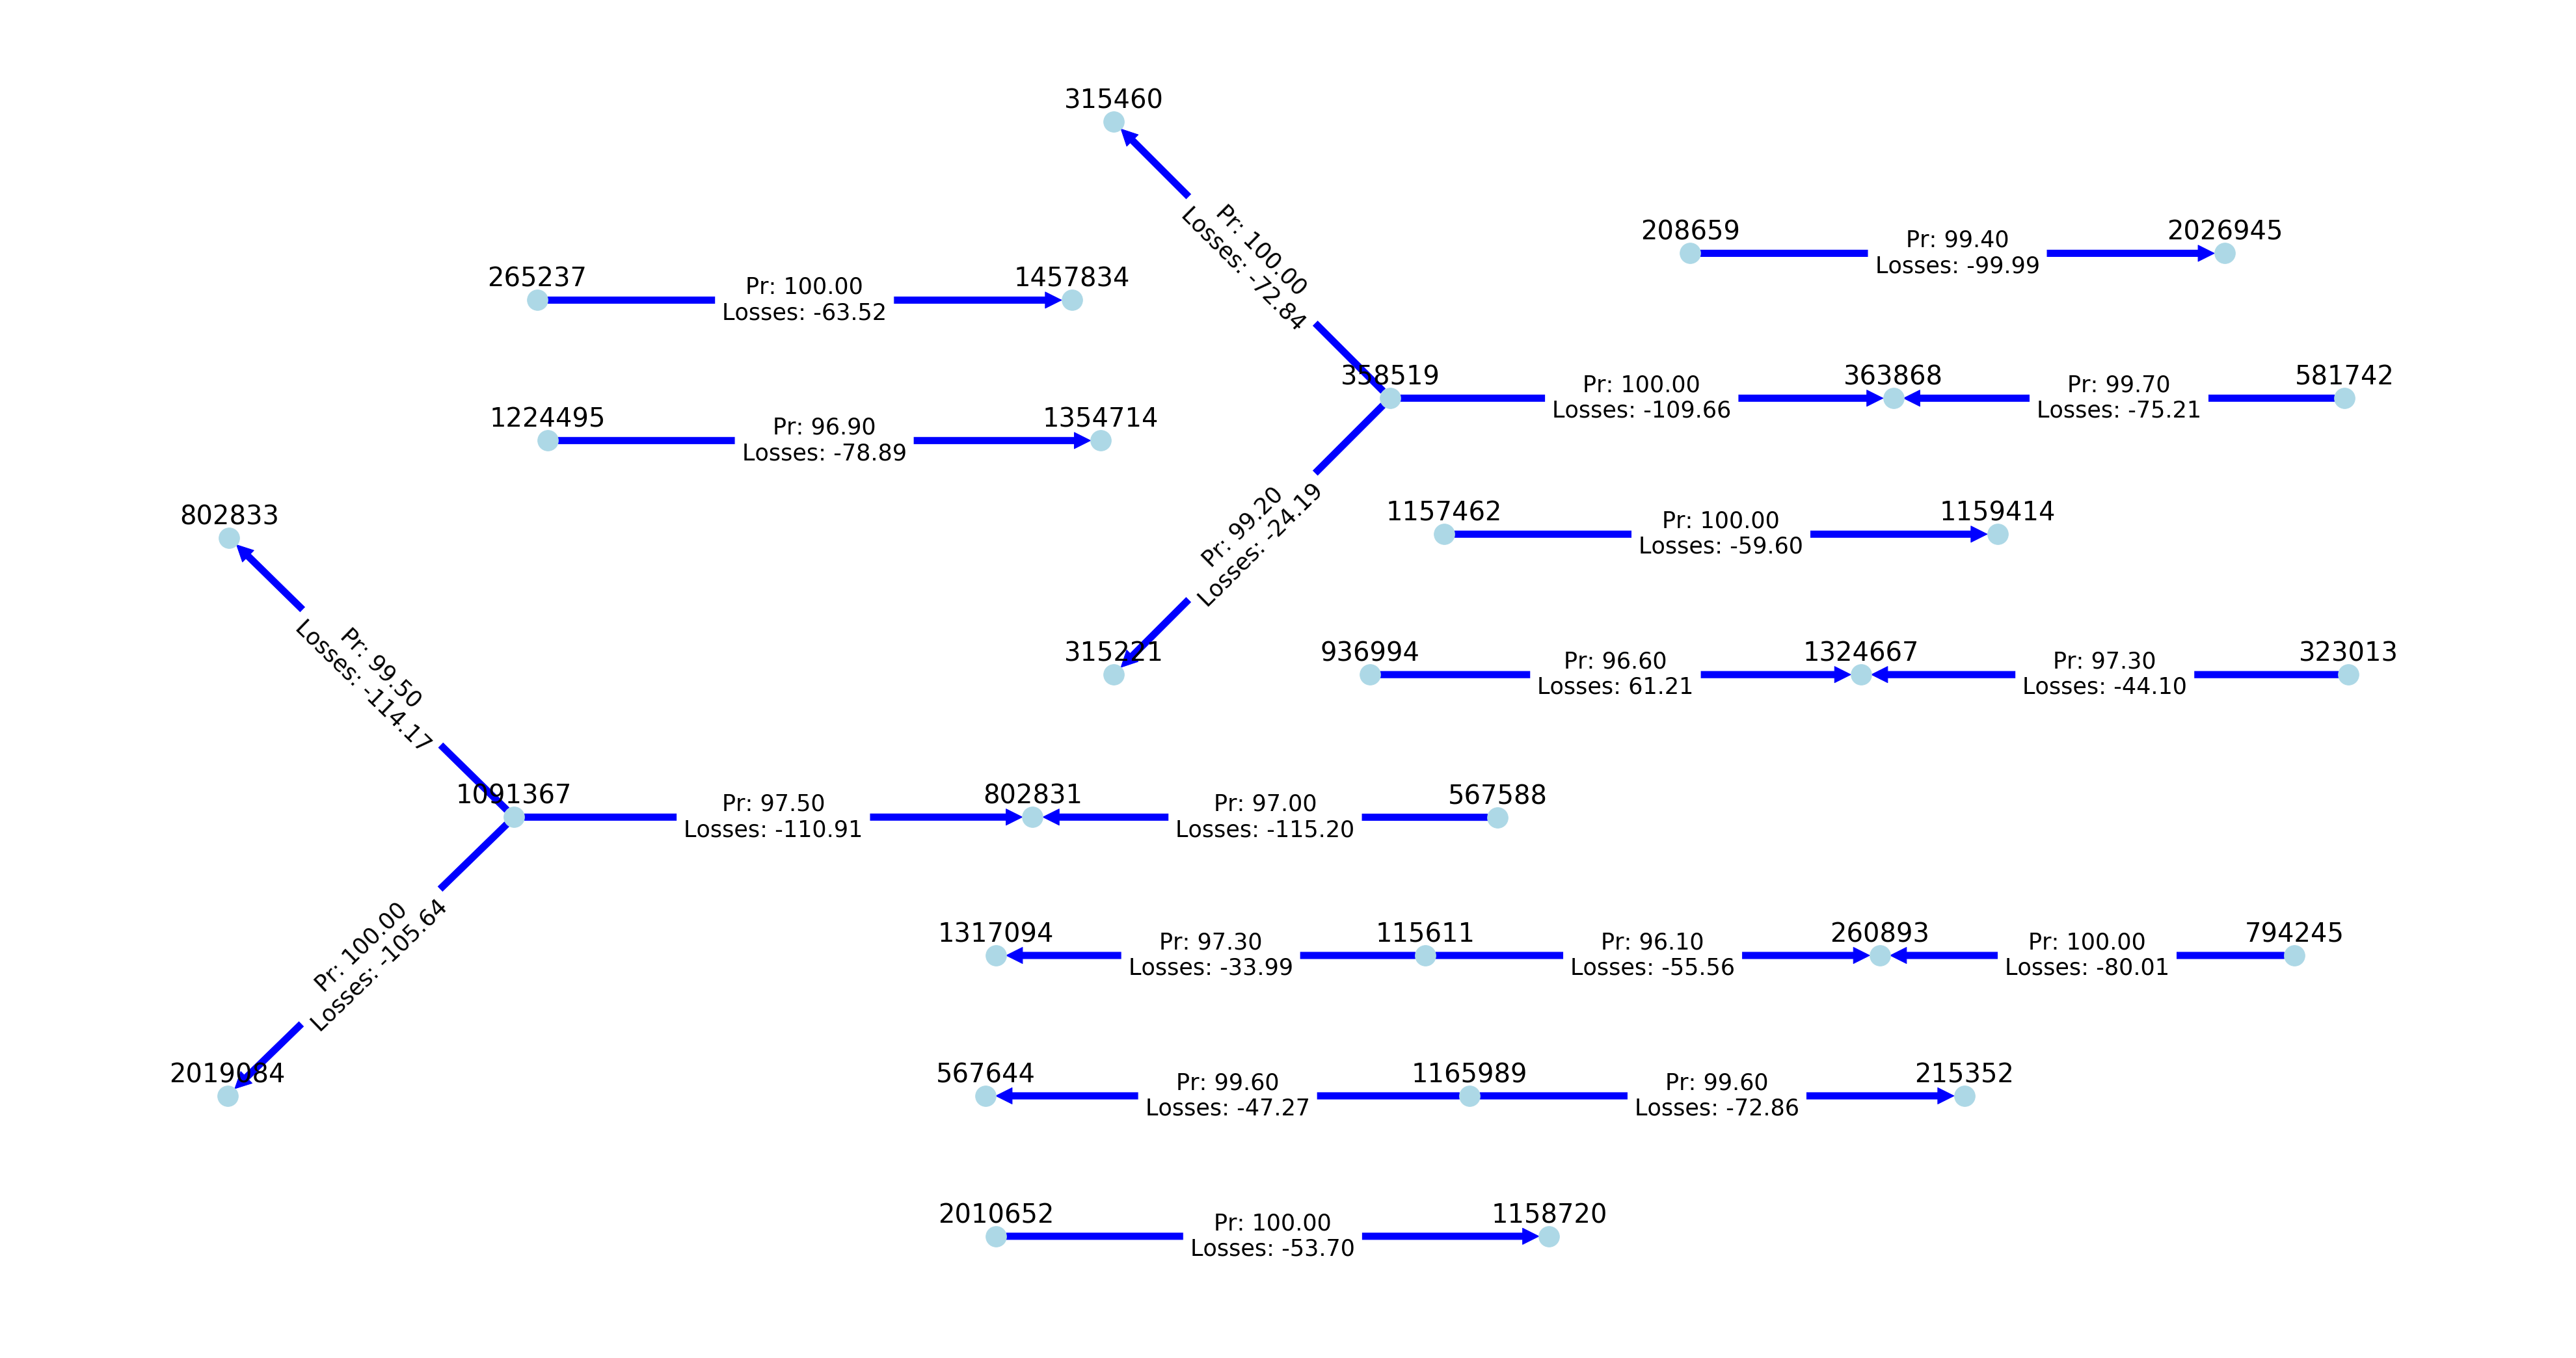

In [23]:
max_episodes = 20

fig_h_graph = 30
fig_w_graph = 56

main_font_size = 40
edge_font_size = 35

fig, ax = plt.subplots(1,1,figsize=(fig_w_graph,fig_h_graph))
text_offset = 8

#fig = plt.figure(figsize=(fig_w,fig_h))

DG = nx.DiGraph()

plt.rcParams.update({'font.size': main_font_size})

#remove some ...
df_CI_to_analyse = df_CI_analysis_paper[0:max_episodes].copy()

# Shorten the names to fit paper's graph
df_CI_to_analyse.cannibal = df_CI_to_analyse.cannibal.apply(lambda s: s.split('_')[-1])
df_CI_to_analyse.victim = df_CI_to_analyse.victim.apply(lambda s: s.split('_')[-1])

vars_edges = ['Pr', 'Losses']
df_CI_to_analyse.rename(columns={'prob_causal_effect': 'Pr', 
                                'cum_abs_effect': 'Losses'}, inplace=True)

for item_id, df_row in df_CI_to_analyse.iterrows():
    node_A = {'name': df_row.cannibal, 'properties': dict()}
    node_B = {'name': df_row.victim, 'properties': dict()}

    edge_properties = df_row[vars_edges].to_dict()

    add_graph_relationship(node_A, node_B, edge_properties)
    

#pos = nx.nx_agraph.graphviz_layout(DG, prog="dot")
#pos = nx.nx_agraph.graphviz_layout(DG, prog="")
pos = nx.nx_agraph.graphviz_layout(DG, prog="sfdp")
#pos = nx.nx_agraph.graphviz_layout(DG, prog="neato")
nx.draw(DG, pos,
    node_color='lightblue',
    linewidths=1.0, 
    node_size=1000,
    with_labels=False, 
    edge_color='b', 
    arrowsize=50,
    arrowstyle='simple')
        
        #,arrowstyle='fancy')
#font_weight='bold', 

'''
nx.draw(DG, pos, \
    node_color='lightblue', linewidths=1.0, font_size=10,
    font_weight='bold', with_labels=False, edge_color='r')
'''

labels = nx.get_edge_attributes(DG, 'label')
nx.draw_networkx_edge_labels(DG, pos, edge_labels=labels, font_size=edge_font_size)
for k, v in pos.items():
    plt.text(v[0],v[1]+text_offset, s=k, horizontalalignment='center')

    
plt.tight_layout()
    
foldername = os.path.join(dataFolder, results_folder, category_id, dept_id, 'graphs')
fhelp.makeFolder(foldername)
plt_filename = os.path.join(foldername, f'cannibals-{store_name}.pdf')

plt.savefig(plt_filename, format='pdf', dpi=300, bbox_inches='tight')


print(f'File saved to {plt_filename}')

In [24]:
DG_gephi = DG.copy()
pos = nx.nx_agraph.graphviz_layout(DG, prog="sfdp")
for n, p in pos.items():
    DG_gephi.nodes[n]['X'] = p[0]
    DG_gephi.nodes[n]['Y'] = p[1]
    
# Export the graph so we can visualise it with Gephi
graph_file = os.path.join(gephiFolder, 'graph_for_Gephi_3.gexf')
nx.write_gexf(DG_gephi, graph_file)
print(f'GEFX saved to {graph_file}')

GEFX saved to /Users/carlos.aguilar/Google Drive/order/Machine Learning Part/data/CorporacionFavorita/gephi_files/graph_for_Gephi_3.gexf


In [28]:
# Save file for GraphViz
dot_filename = os.path.join(gephiFolder, f'graph_for_GraphViz.dot')
print(f'Writing {dot_filename}...')
from networkx.drawing.nx_agraph import write_dot
write_dot(DG_gephi, dot_filename)


gml_filename = os.path.join(gephiFolder, f'graph_for_Graphia.gml')
print(f'Writing {gml_filename}...')
nx.write_gml(DG_gephi, gml_filename)


graphml_filename = os.path.join(gephiFolder, f'graph_for_Graphia.graphml')
print(f'Writing {graphml_filename}...')
nx.write_graphml(DG_gephi, graphml_filename)

Writing /Users/carlos.aguilar/Google Drive/order/Machine Learning Part/data/CorporacionFavorita/gephi_files/graph_for_GraphViz.dot...
Writing /Users/carlos.aguilar/Google Drive/order/Machine Learning Part/data/CorporacionFavorita/gephi_files/graph_for_Graphia.gml...
Writing /Users/carlos.aguilar/Google Drive/order/Machine Learning Part/data/CorporacionFavorita/gephi_files/graph_for_Graphia.graphml...
